In [44]:
# Install the required libraries
!pip install prophet
!pip install geopandas shapely fiona pyproj rtree
!pip install geodatasets

In [58]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point
import geodatasets
import matplotlib.patches as mpatches


In [46]:
# Define the file path
file_path = "Crime_Data.csv"

# Read the CSV file into a DataFrame with correct date format
crime_df = pd.read_csv(file_path)

# Trim any spaces from column names
crime_df.columns = crime_df.columns.str.strip()

# Convert Date column to datetime with mixed format handling
crime_df["Date"] = pd.to_datetime(crime_df["Date"], dayfirst=True, errors='coerce')

# Drop rows where Date conversion failed
crime_df = crime_df.dropna(subset=["Date"])

# Set Date as the index
crime_df.set_index("Date", inplace=True)

# Ensure the index is sorted
crime_df = crime_df.sort_index()

# Display unique values in 'Major Category' to check for mismatches
print("Unique Major Categories:", crime_df["Major Category"].unique())

# Review the first and last five rows of the DataFrame
display(crime_df.head())
display(crime_df.tail())

Unique Major Categories: ['Murder' 'Rough and Rowdy Behavior' 'Impaired Driving'
 'Crimes Involving Children' 'Drugs and Alcohol (non-driving)' 'Assault'
 'Traffic Violation' 'Burglary Related' 'Weapons Charges' 'Fraud'
 'Sexual Crimes' 'Arson' 'Kidnapping']


Unique ID      Time                        OFNS_DESC  \
Date                                                               
2014-01-01  299199640   2:54:00  MURDER & NON-NEGL. MANSLAUGHTER   
2014-01-01  356245875   1:00:00   CRIMINAL MISCHIEF & RELATED OF   
2014-01-01  620816682  12:00:00   CRIMINAL MISCHIEF & RELATED OF   
2014-01-01  691848121   0:01:00   CRIMINAL MISCHIEF & RELATED OF   
2014-01-01  552279440   0:01:00   CRIMINAL MISCHIEF & RELATED OF   

                      Major Category      Jurisdiction        Borough  \
Date                                                                    
2014-01-01                    Murder  N.Y. POLICE DEPT       BROOKLYN   
2014-01-01  Rough and Rowdy Behavior  N.Y. POLICE DEPT  STATEN ISLAND   
2014-01-01  Rough and Rowdy Behavior  N.Y. POLICE DEPT         QUEENS   
2014-01-01  Rough and Rowdy Behavior  N.Y. POLICE DEPT       BROOKLYN   
2014-01-01  Rough and Rowdy Behavior  N.Y. POLICE DEPT         QUEENS   

            Precinct  X_COORD_CD  Y_COORD_CD   Latitude  Longitude  \
Date                                                                 
2014-01-01      83.0   1009904.0    188287.0  40.683452 -73.907504   
2014-01-01     121.0    942595.0    167112.0  40.625271 -74.150060   
2014-01-01     112.0   1025624.0    206222.0  40.732620 -73.850715   
2014-01-01      62.0    984125.0    162548.0  40.612841 -74.000452   
2014-01-01     109.0   1039431.0    208469.0  40.738712 -73.800878   

                                  Lat_Lon  
Date                                       
2014-01-01  (40.683452127, -73.907504449)  
2014-01-01    (40.625270607, -74.1500601)  
2014-01-01  (40.732619877, -73.850714956)  
2014-01-01  (40.612841308, -74.000451659)  
2014-01-01  (40.738711964, -73.800877984)

Unique ID     Time                       OFNS_DESC  \
Date                                                             
2015-12-12  730973342  2:45:00  CRIMINAL MISCHIEF & RELATED OF   
2015-12-12  200380981  3:25:00  CRIMINAL MISCHIEF & RELATED OF   
2015-12-12  768432022  4:00:00  CRIMINAL MISCHIEF & RELATED OF   
2015-12-12  190967808  4:30:00  CRIMINAL MISCHIEF & RELATED OF   
2015-12-12  893639874  1:42:00  OTHER OFFENSES RELATED TO THEF   

                      Major Category         Jurisdiction    Borough  \
Date                                                                   
2015-12-12  Rough and Rowdy Behavior     N.Y. POLICE DEPT  MANHATTAN   
2015-12-12  Rough and Rowdy Behavior     N.Y. POLICE DEPT   BROOKLYN   
2015-12-12  Rough and Rowdy Behavior  N.Y. HOUSING POLICE      BRONX   
2015-12-12  Rough and Rowdy Behavior     N.Y. POLICE DEPT      BRONX   
2015-12-12          Burglary Related     N.Y. POLICE DEPT  MANHATTAN   

            Precinct  X_COORD_CD  Y_COORD_CD   Latitude  Longitude  \
Date                                                                 
2015-12-12      17.0    991748.0    214083.0  40.754290 -73.972938   
2015-12-12      83.0   1008057.0    194042.0  40.699253 -73.914144   
2015-12-12      42.0   1010466.0    243220.0  40.834227 -73.905264   
2015-12-12      50.0   1012789.0    259873.0  40.879928 -73.896798   
2015-12-12       1.0    982761.0    204595.0  40.728251 -74.005374   

                                  Lat_Lon  
Date                                       
2015-12-12  (40.754289948, -73.972938227)  
2015-12-12   (40.69925343, -73.914143574)  
2015-12-12   (40.83422741, -73.905263926)  
2015-12-12  (40.879927685, -73.896798343)  
2015-12-12  (40.728250797, -74.005373732)

Number of filtered drug and alcohol-related crimes: 22115


C:\Users\Edwar\AppData\Local\Temp\ipykernel_2520\3002461028.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  drug_alcohol_crimes_monthly = drug_alcohol_crimes_filtered.resample("M").size()


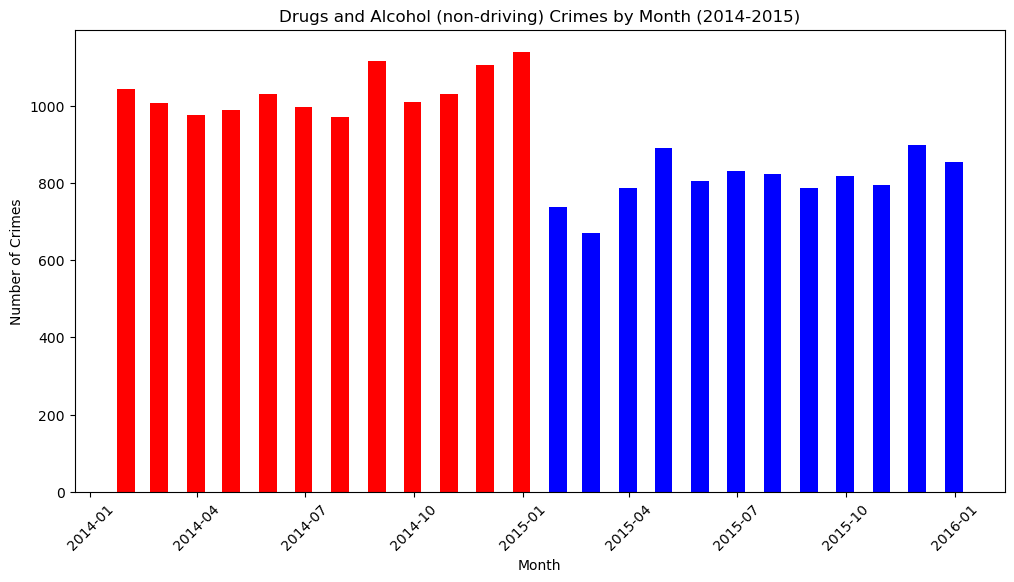

In [37]:
# Filter for Drugs and Alcohol (non-driving) related crimes
drug_alcohol_crimes = crime_df[crime_df["Major Category"].str.contains("Drugs|Alcohol", case=False, na=False)]

# Debugging output
print("Number of filtered drug and alcohol-related crimes:", len(drug_alcohol_crimes))

# Filter for 2014 and 2015
drug_alcohol_crimes_filtered = drug_alcohol_crimes.loc["2014-01-01":"2015-12-31"]

# Check if the filtered DataFrame is empty
if drug_alcohol_crimes_filtered.empty:
    print("No data available for the specified category and date range.")
else:
    # Create bar chart with different colors for 2014 and 2015
    drug_alcohol_crimes_monthly = drug_alcohol_crimes_filtered.resample("M").size()
    colors = ["red" if date.year == 2014 else "blue" for date in drug_alcohol_crimes_monthly.index]
    
    plt.figure(figsize=(12, 6))
    plt.bar(drug_alcohol_crimes_monthly.index, drug_alcohol_crimes_monthly, color=colors, width=15)
    plt.title("Drugs and Alcohol (non-driving) Crimes by Month (2014-2015)")
    plt.xlabel("Month")
    plt.ylabel("Number of Crimes")
    plt.xticks(rotation=45)
    plt.show()

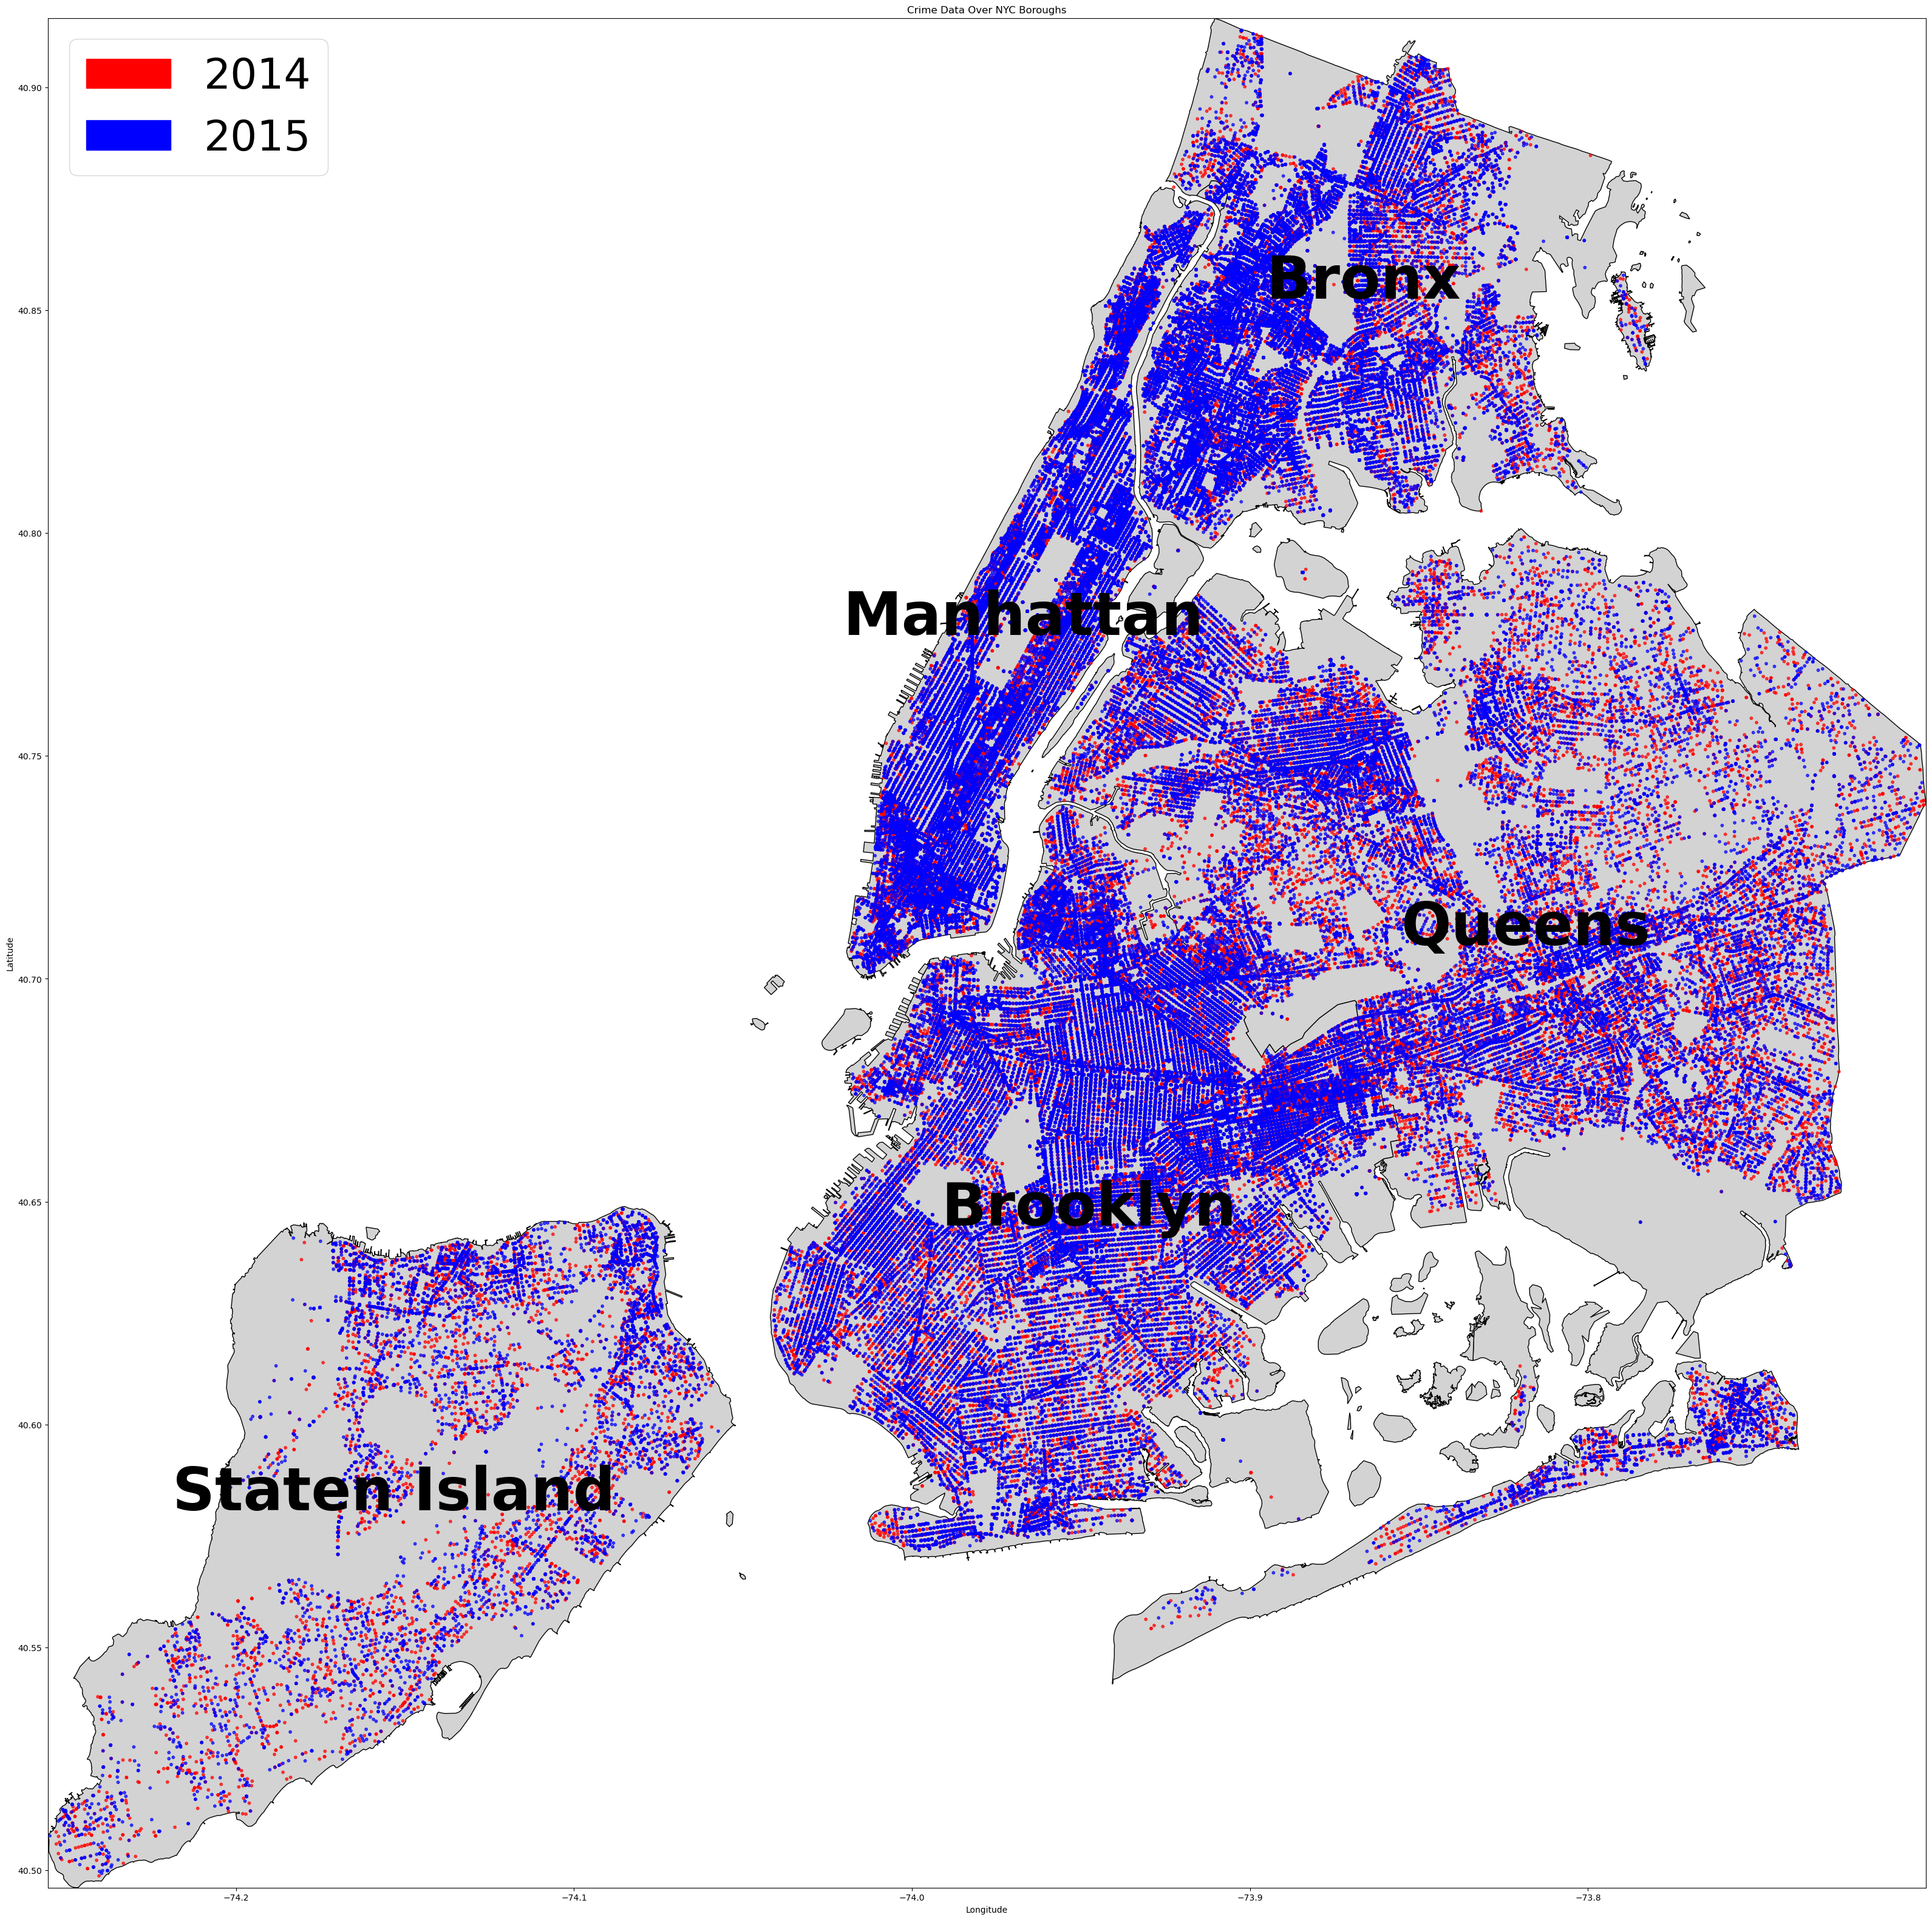

In [64]:
# Load NYC borough map using geodatasets
nyc_map = gpd.read_file(geodatasets.get_path("nybb"))

# Ensure CRS is consistent
nyc_map = nyc_map.to_crs(epsg=4326)

# Filter for valid latitude and longitude values
crime_df = crime_df.dropna(subset=["Latitude", "Longitude"])

# Convert latitude and longitude to a GeoDataFrame
gdf = gpd.GeoDataFrame(crime_df, geometry=[Point(xy) for xy in zip(crime_df["Longitude"], crime_df["Latitude"])] )
gdf.set_crs(epsg=4326, inplace=True)

# Assign colors based on year
gdf["color"] = np.where(gdf.index.year == 2014, "red", "blue")

# Get the bounds of the NYC map to adjust plot limits
xmin, ymin, xmax, ymax = nyc_map.total_bounds

# Plot map
fig, ax = plt.subplots(figsize=(40, 40))
nyc_map.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, markersize=10, color=gdf["color"], alpha=0.7, marker='o', legend=True)

# Add labels for each borough
for _, row in nyc_map.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["BoroName"], fontsize=70, ha='center', color='black', fontweight='bold')

# Create legend patches with adjusted size
red_patch = mpatches.Patch(color='red', label='2014')
blue_patch = mpatches.Patch(color='blue', label='2015')
ax.legend(handles=[red_patch, blue_patch], loc='upper left', fontsize=50)

# Set plot limits to NYC borough bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.title("Crime Data Over NYC Boroughs")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
